# Techniques to speed up Fisher Information evaluation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import statsmodels.api as sm

import glob
import torch

In [2]:
from basicModel import EstimateAngle_Faces_final, EstimateAngle_Faces
from datageneration.faces.rotated_olivetti import FaceDataset

In [3]:
ckpt = 'trainedParameters/Exp8/dropout/linear/low_conc/rep0/epoch=571-step=146432.ckpt'
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

%run discriminationAnalysis.py

### Is it faster to evaluate all of the derivatives at once?

In [4]:
I0 = FaceDataset(torch.zeros(80), split='test').images.contiguous()
I0.requires_grad = True

In [6]:
outs = model.forward(I0.repeat((100, 1, 1)).to(model.device)).cpu()

In [13]:
%%timeit

outputs = model.forward(I0.repeat((100, 1, 1)).to(model.device)).cpu()
cov = outputs.T.cov()

mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]

cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]

102 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit

cov_jac = torch.autograd.functional.jacobian(lambda x: model(x.repeat((100,1,1)).to(model.device)).cpu().T.cov(), I0 )
mean_jac = torch.autograd.functional.jacobian(lambda x: model(x.repeat((100,1,1)).to(model.device)).cpu().mean(0), I0 )

118 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Can we same memory by not copying all of the input data?

In [4]:
I0 = FaceDataset(torch.zeros(80), split='test').images.contiguous()
I0.requires_grad = True

In [5]:
test = I0.to(model.device).expand(1000, 80, 64, 64).view(1000, 80, 64*64)

376 MB of ram used

In [5]:
test = I0.repeat((1000, 1, 1)).to(model.device)

1.54 GB of ram used

In [8]:
outs = model.model.forward(
                I0.to(model.device).expand(1000, 80, 64, 64).view(1000, 80, 64*64)
                          ).cpu()

1.60 GB of ram used

In [5]:
outs = model.forward(I0.repeat((1000, 1, 1)).to(model.device)).cpu()

1.60 GB of ram used

Interestingly, this doesn't seem to save any ram.

In [6]:
outs = model.model.forward(I0.view(80, 64*64).to(model.device)).cpu().repeat((1000, 1, 1))

400 MB ram used: it is not the output size alone that account for this

In [5]:
outs = model.forward(I0.repeat((10000, 1, 1)).to(model.device)).cpu()

RuntimeError: Invalid buffer size: 12.21 GB

10000 repeats saturates the device memory

In [14]:
I0 = FaceDataset(torch.zeros(80), split='test').images.contiguous()
I0.requires_grad = True

outs = model.model.forward(
                I0.to(model.device).expand(10000, 80, 64, 64).view(10000, 80, 64*64)
                          ).cpu()

RuntimeError: Invalid buffer size: 12.21 GB

Same problem here. It looks like the data is copied on the device, even if its expanded.

In [16]:
def run_repeats(data):
    outs = model.model(data.to(model.device).expand(10000, 80, 64, 64).view(10000, 80, 64*64))
    return outs.cpu().mean(0)
    
mean_jac = torch.autograd.functional.jacobian(run_repeats, I0 )

RuntimeError: Invalid buffer size: 12.21 GB

Running with Jacobian changes nothing.

#### Explaination:
Note that the number of samples from middle layers of the network scales up, even if the underlying data is not fully copied. This means that, as we increase the number of replicates, we still need to hold that many times the network activities in memory.

Only way around this would be to average somewhere, which I can't really see.

## Is the loop actually slower than running in parallel?

In [4]:
%%timeit

I0 = FaceDataset(torch.zeros(80*5), split='test').images.contiguous()
I0.requires_grad = True
num_samples = 100

outputs = model.forward(I0.repeat((num_samples, 1, 1)).to(model.device)).cpu()
cov = outputs.T.cov()

mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]

cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]

cov = cov.detach()

620 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
torch.mps.empty_cache()

In [6]:
%%timeit

for rep in range(5):
    I0 = FaceDataset(torch.zeros(80), split='test').images.contiguous()
    I0.requires_grad = True
    num_samples = 100
    
    outputs = model.forward(I0.repeat((num_samples, 1, 1)).to(model.device)).cpu()
    cov = outputs.T.cov()
    
    mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
    mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]
    
    cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
    cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
    cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
    cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]
    
    cov = cov.detach()

645 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


No. Running different inputs in parallel is not significantly faster.

In [7]:
torch.mps.empty_cache()

In [8]:
%%timeit

for rep in range(5):
    I0 = FaceDataset(torch.zeros(80), split='test').images.contiguous()
    I0.requires_grad = True
    num_samples = 100
    
    outputs = model.forward(I0.to(model.device).repeat((num_samples, 1, 1))).cpu()
    cov = outputs.T.cov()
    
    mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
    mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]
    
    cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
    cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
    cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
    cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]
    
    cov = cov.detach()

276 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Repeating data _while on the device_ is significantly faster.

In [9]:
torch.mps.empty_cache()

In [10]:
%%timeit

I0 = FaceDataset(torch.zeros(80*5), split='test').images.contiguous()
I0.requires_grad = True
num_samples = 100

outputs = model.forward(I0.to(model.device).repeat((num_samples, 1, 1))).cpu()
cov = outputs.T.cov()

mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]

cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]

cov = cov.detach()

206 ms ± 5.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Here we do see savings from sending the data to the device only once

In [11]:
torch.mps.empty_cache()

### Interim summary

It seems like the best place to save time is in data copying to the gpu. The two principles seem to be:
1. copy as little data as possible
2. copy the data all at once


In [4]:
I0 = FaceDataset(torch.zeros(80*5), split='test').images.contiguous()

In [5]:
%%timeit
# cost of moving to the device once

I0.to(model.device)

301 µs ± 9.76 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
torch.mps.empty_cache()

In [7]:
%%timeit
# cost of moving 1000x data to the device 

I0.repeat(1000, 1,1).to(model.device)

The slowest run took 4.10 times longer than the fastest. This could mean that an intermediate result is being cached.
1.06 s ± 478 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
torch.mps.empty_cache()

In [9]:
%%timeit
# cost of moving to the device 1000 times
for rep in range(1000):
    I0.to(model.device)

327 ms ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
torch.mps.empty_cache()

In [11]:
%%timeit
# repeating on the device

I0.to(model.device).repeat(1000, 1,1)

154 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
torch.mps.empty_cache()

In [13]:
%%timeit
# moving small data to device + replicating on cpu

I0.to(model.device)
I0.repeat(1000, 1, 1)

266 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
torch.mps.empty_cache()

#### continued

3. Repeating data is (much) faster on the mps device than with the cpu
4. Copying larger amounts of data to the device is much slower than repeatedly copying small amounts of data. This is probably because of the need to shuffle around other data in and out of device memory

In [4]:
%run discriminationAnalysis.py

In [5]:
%%time

FIs = Fisher_derivatives_faces_total(model, torch.linspace(0, 1.5, 10))

CPU times: user 35.2 s, sys: 52.9 s, total: 1min 28s
Wall time: 13.8 s


In [6]:
%%time

FIs2 = Fisher_derivatives_faces_optimized(model, torch.linspace(0, 1.5, 10), num_samples=1000)

CPU times: user 11 s, sys: 30.9 s, total: 42 s
Wall time: 6.26 s


Optimization savings

In [7]:
FIs

array([ 39.59051514,  43.50375366,  75.70122528, 117.34266663,
       105.6969986 ,  73.07595062,  64.09072876,  87.08837891,
        75.10900116,  48.39936066])

In [8]:
FIs2

array([ 39.57792664,  44.47847366,  75.1032486 , 116.47589874,
       105.97788239,  73.480896  ,  63.86983109,  83.55896759,
        75.60709381,  51.27737045])

In [9]:
I0 = FaceDataset(torch.zeros(80), split='test').images.contiguous()
I0.requires_grad = True
outputs = model.forward(I0.to(model.device).repeat((1000, 1, 1)))

In [10]:
%%timeit

mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0].cpu()

84.4 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit

mean_grad0 = torch.autograd.grad(outputs.cpu().mean(0)[0], I0, retain_graph=True)[0]

76.9 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Not significantly different.

#### Testing vectorized vs loop again

In [10]:
%%timeit

I0 = FaceDataset(torch.zeros(80*5), split='test').images.contiguous()
I0.requires_grad = True
num_samples = 100

outputs = model.forward(I0.to(model.device).repeat((num_samples, 1, 1))).cpu()
cov = outputs.T.cov()

mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]

cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]

cov = cov.detach()

204 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
torch.mps.empty_cache()

In [12]:
%%timeit

for rep in range(5):
    I0 = FaceDataset(torch.zeros(80), split='test').images.contiguous()
    I0.requires_grad = True
    num_samples = 100
    
    outputs = model.forward(I0.to(model.device).repeat((num_samples, 1, 1))).cpu()
    cov = outputs.T.cov()
    
    mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
    mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]
    
    cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
    cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
    cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
    cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]
    
    cov = cov.detach()

267 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now there _is_ some savings to be had.

In [19]:
def n_vectorized(n, num_samples=100):
    I0 = FaceDataset(torch.zeros(80*n), split='test').images.contiguous()
    I0.requires_grad = True
    
    outputs = model.forward(I0.to(model.device).repeat((num_samples, 1, 1))).cpu()
    cov = outputs.T.cov()
    
    mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
    mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]
    
    cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
    cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
    cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
    cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]
    
    cov = cov.detach()

def n_replicates(n, num_samples=100):
    for rep in range(n):
        I0 = FaceDataset(torch.zeros(80), split='test').images.contiguous()
        I0.requires_grad = True
        
        outputs = model.forward(I0.to(model.device).repeat((num_samples, 1, 1))).cpu()
        cov = outputs.T.cov()
        
        mean_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
        mean_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0, retain_graph=True)[0]
        
        cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
        cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
        cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
        cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]
        
        cov = cov.detach()

In [15]:
vector_mean = []
vector_std = []

replicate_mean = []
replicate_std = []

ns = [5, 10, 15, 20, 25, 30]

for n in ns:
    vec_result = %timeit -o n_vectorized(n)
    vector_mean.append(vec_result.average)
    vector_std.append(vec_result.stdev)
    torch.mps.empty_cache()

    rep_result = %timeit -o n_replicates(n)
    replicate_mean.append(rep_result.average)
    replicate_std.append(rep_result.stdev)
    torch.mps.empty_cache()

209 ms ± 7.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
278 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
467 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
533 ms ± 8.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
574 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
802 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.14 s ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.18 s ± 65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
993 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.41 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.42 s ± 45.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.69 s ± 68.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


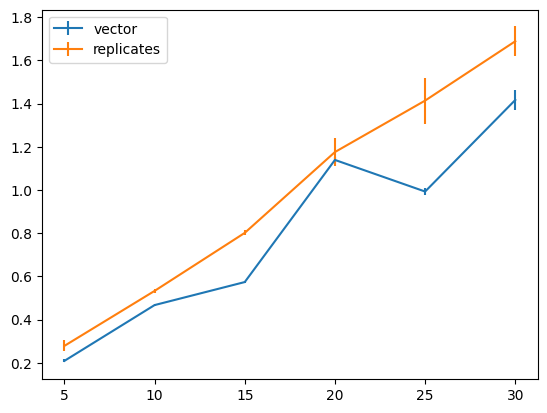

In [17]:
plt.errorbar(ns, vector_mean, yerr=vector_std, label='vector')
plt.errorbar(ns, replicate_mean, yerr=replicate_std, label='replicates')
plt.legend()

In [9]:
vector_mean = []
vector_std = []

replicate_mean = []
replicate_std = []

ns = [5, 10, 20, 30, 50, 100]

for n in ns:
    vec_result = %timeit -o n_vectorized(n)
    vector_mean.append(vec_result.average)
    vector_std.append(vec_result.stdev)
    torch.mps.empty_cache()

    rep_result = %timeit -o n_replicates(n)
    replicate_mean.append(rep_result.average)
    replicate_std.append(rep_result.stdev)
    torch.mps.empty_cache()

205 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
261 ms ± 8.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
477 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
585 ms ± 54.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.13 s ± 5.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.14 s ± 56.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.47 s ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.75 s ± 68.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.59 s ± 1.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.97 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


RuntimeError: Invalid buffer size: 12.21 GB

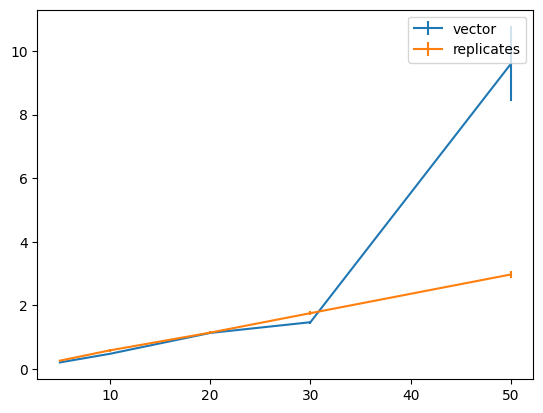

In [14]:
plt.errorbar(ns[:-1], vector_mean, yerr=vector_std, label='vector')
plt.errorbar(ns[:-1], replicate_mean, yerr=replicate_std, label='replicates')
plt.legend()

#### Benefits of vectorizing

The vectorized version performs better up until ~30 datapoints, at which point it becomes drastically slower, and eventually fails altogether.

In [20]:
vector_mean = []
vector_std = []

replicate_mean = []
replicate_std = []

ns = [5, 10, 15, 20, 25, 30]

for n in ns:
    vec_result = %timeit -o n_vectorized(n, num_samples=500)
    vector_mean.append(vec_result.average)
    vector_std.append(vec_result.stdev)
    torch.mps.empty_cache()

    rep_result = %timeit -o n_replicates(n, num_samples=500)
    replicate_mean.append(rep_result.average)
    replicate_std.append(rep_result.stdev)
    torch.mps.empty_cache()

1.28 s ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.35 s ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.17 s ± 322 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.72 s ± 64.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


RuntimeError: Invalid buffer size: 9.16 GB

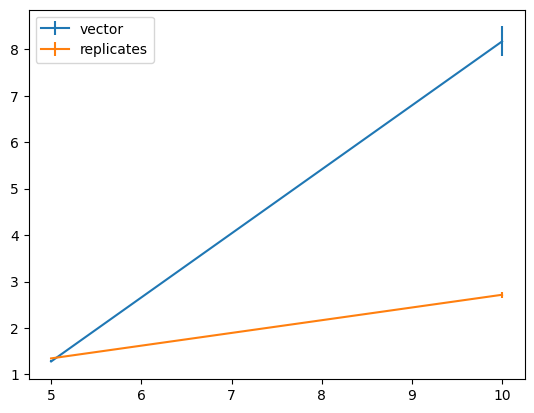

In [22]:
plt.errorbar(ns[0:2], vector_mean, yerr=vector_std, label='vector')
plt.errorbar(ns[0:2], replicate_mean, yerr=replicate_std, label='replicates')
plt.legend()

The benefits also go away if the number of replicates is scaled up.



In [31]:
from scipy import integrate

In [39]:
%run discriminationAnalysis.py
model

EstimateAngle_Faces_final(
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=30, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=30, out_features=10, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
  (cosSim): CosineSimilarity()
)

<Figure size 640x480 with 0 Axes>

In [33]:
integrate.quad(lambda xs:  Fisher_derivatives_faces_optimized(model, xs, num_samples=1000), 0, 0.1)

0.05
0.001304673574141413
0.0986953264258586
0.006746831665550773
0.09325316833444923
0.016029521585048778
0.08397047841495123
0.02833023029353764
0.07166976970646237
0.04255628305091844
0.05744371694908156
0.00021714184870959554
0.09978285815129041
0.003492125432214588
0.09650787456778542
0.010959113670679156
0.08904088632932085
0.021862143266569767
0.07813785673343024
0.03528035686492699
0.06471964313507302
0.025
0.0006523367870707065
0.0493476632129293
0.0033734158327753867
0.046626584167224615
0.008014760792524389
0.041985239207475614
0.01416511514676882
0.035834884853231184
0.02127814152545922
0.02872185847454078
0.00010857092435479777
0.049891429075645206
0.001746062716107294
0.04825393728389271
0.005479556835339578
0.044520443164660424
0.010931071633284883
0.03906892836671512
0.017640178432463495
0.03235982156753651
0.07500000000000001
0.05065233678707071
0.0993476632129293
0.0533734158327754
0.09662658416722462
0.0580147607925244
0.09198523920747562
0.06416511514676883
0.085834

KeyboardInterrupt: 

In [41]:
FIs = []
for rep in range(5):
    FI = Fisher_derivatives_faces_optimized(model, np.linspace(0, 0.1, 15), num_samples=1000)
    FIs.append(FI)
    print(rep)

0
1
2
3
4


In [43]:
FIs2 = []
for rep in range(5):
    FI = Fisher_derivatives_faces_optimized(model, np.linspace(0.01, 0.11, 15), num_samples=1000)
    FIs2.append(FI)
    print(rep)

0
1
2
3
4


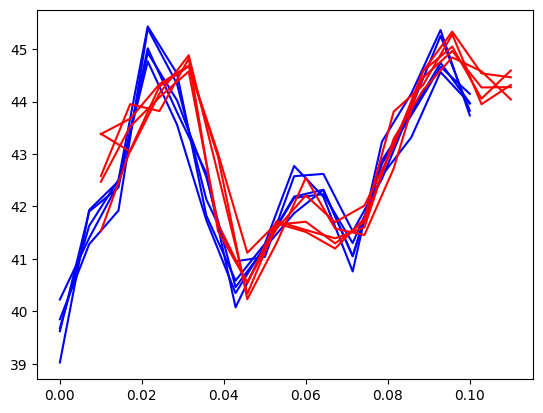

In [45]:
for FI in FIs:
    plt.plot(np.linspace(0, 0.1, 15), FI, 'b')

for FI in FIs2:
    plt.plot(np.linspace(0.01, 0.11, 15), FI, 'r')

In [4]:
FIs = []
for rep in range(7):
    FI = Fisher_derivatives_faces_optimized(model, np.linspace(0, 0.1, 25), num_samples=1000)
    FIs.append(FI)
    print(rep)

0
1
2
3
4
5
6


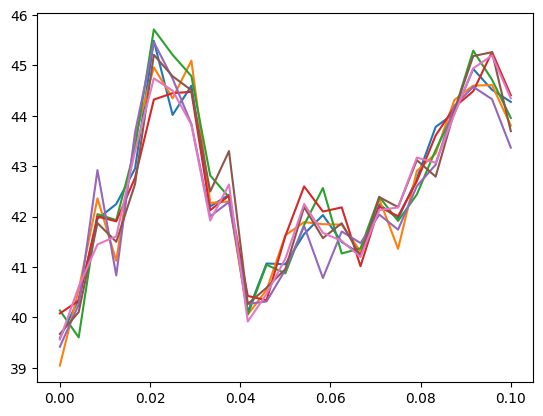

In [5]:
for FI in FIs:
    plt.plot(np.linspace(0, 0.1, 25), FI)

In [6]:
FIs = []
for rep in range(7):
    FI = Fisher_derivatives_faces_optimized(model, np.linspace(0, 0.1, 25), num_samples=2000)
    FIs.append(FI)
    print(rep)

0
1
2
3
4
5
6


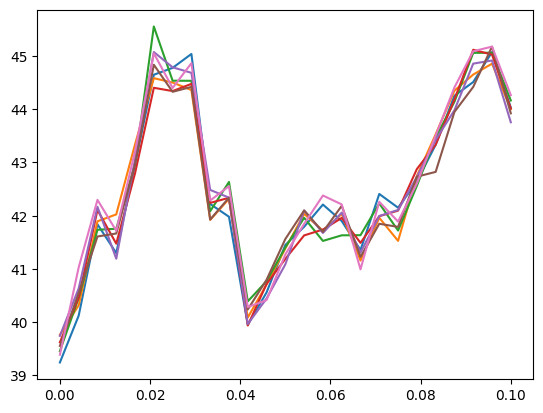

In [7]:
for FI in FIs:
    plt.plot(np.linspace(0, 0.1, 25), FI)